In [31]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import sys, importlib
from scripts.classes import Label, Sample
import scripts.util as util
importlib.reload(sys.modules['scripts.util'])

<module 'scripts.util' from 'c:\\Users\\Thai\\Desktop\\uSask\\CMPT318\\CMPT318Project\\src\\scripts\\util.py'>

In [34]:
# Get data
# x_train will be the image itself
# y_train will be the labels
# similarly, x_test will be the images and y_test will be the labels
# same for x_validation and y_validation

TRAIN_DATA = "../data/EuroSatData/train.csv"
TEST_DATA = "../data/EuroSatData/test.csv"
VALIDATION_DATA = "../data/EuroSatData/validation.csv"

train_df = pd.read_csv(TRAIN_DATA)
train_df["Filename"] = "../data/EuroSatData/" + train_df["Filename"].astype(str)
test_df = pd.read_csv(TEST_DATA)
test_df["Filename"] = "../data/EuroSatData/" + test_df["Filename"].astype(str)
validation_df = pd.read_csv(VALIDATION_DATA)
validation_df["Filename"] = "../data/EuroSatData/" + validation_df["Filename"].astype(str)

train_df["Image"] = train_df["Filename"].apply(util.read_img)
test_df["Image"] = test_df["Filename"].apply(util.read_img)
validation_df["Image"] = validation_df["Filename"].apply(util.read_img)

In [35]:
x_train, y_train = train_df["Image"], train_df["Label"]
x_test, y_test = test_df["Image"], test_df["Label"]
x_validation, y_validation = validation_df["Image"], validation_df["Label"]


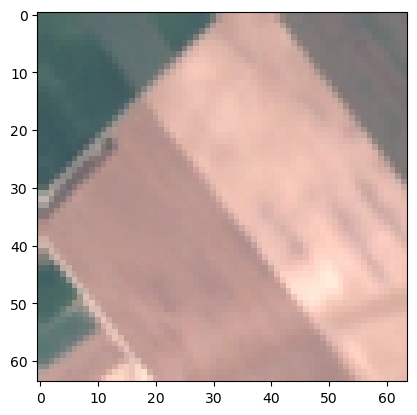

In [38]:
x_train[0]

In [ ]:
pretrained_vgg16 = tf.keras.applications.vgg16.VGG16()

In [2]:
pretrained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
model = tf.keras.Sequential()

In [4]:
# Ignore the last layer, which is the dense layer
for layer in pretrained_vgg16.layers[:-1]:
  model.add(layer)


In [6]:
model.trainable = True

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
model.compile(
  optimizer=tf.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"]
)